In [21]:
import os
import pandas as pd
import numpy as np
import h2o
from tpot import TPOTRegressor
from h2o.automl import H2OAutoML
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

# H2O AI

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Abhinav\AppData\Local\Temp\tmpchyv3_2g
  JVM stdout: C:\Users\Abhinav\AppData\Local\Temp\tmpchyv3_2g\h2o_Abhinav_started_from_python.out
  JVM stderr: C:\Users\Abhinav\AppData\Local\Temp\tmpchyv3_2g\h2o_Abhinav_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,"21 days, 21 hours and 59 minutes"
H2O cluster name:,H2O_from_python_Abhinav_k8c75m
H2O cluster total nodes:,1
H2O cluster free memory:,3.528 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
def get_data():
    train = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/train.csv')
    test = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/test.csv')
    return train, test

In [4]:
def preprocessing_data(train,test):
    global categoricalFeatureNames,numericalFeatureNames
    
    #Combining Test and Train Frames
    data = train.append(test)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Deriving Time Series Columns from datetime field
    data["date"] = data.datetime.apply(lambda x : x.split()[0])
    data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
    data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0]).astype('int')
    data["weekday"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").weekday())
    data["month"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").month)
    
    #Predicting Missing Wind Values using RF Regressor
    dataWind0 = data[data["windspeed"]==0]
    dataWindNot0 = data[data["windspeed"]!=0]
    rfModel_wind = RandomForestRegressor()
    windColumns = ["season","weather","humidity","month","temp","year","atemp"]
    rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
    wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
    dataWind0["windspeed"] = wind0Values
    data = dataWindNot0.append(dataWind0)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Designating Categorical Features from numeric columns
    categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
    numericalFeatureNames = ["atemp","humidity","windspeed"]
    dropFeatures = ["casual","datetime","date","registered","temp"]
        
    dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
    dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
    
    dataTrain  = dataTrain.drop(dropFeatures,axis=1)
    dataTest  = dataTest.drop(dropFeatures,axis=1)
    dataTest = dataTest.drop('count',axis=1)
    
    return dataTrain,dataTest

In [5]:
raw_train, raw_test = get_data()
pro_train, pro_test = preprocessing_data(raw_train,raw_test)

In [6]:
h2o_train = h2o.H2OFrame(pro_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
for item in ['holiday','season','weather','workingday','weekday','hour','year','month']:
    h2o_train[item] = h2o_train[item].asfactor()

In [8]:
h2o_test = h2o.H2OFrame(pro_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
h2o_raw_test = h2o.H2OFrame(raw_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [10]:
train,test,_ = h2o_train.split_frame([0.7,0.25])

In [11]:
run_time_secs = 240

aml = H2OAutoML(max_runtime_secs = run_time_secs, project_name='Final Project')

In [12]:
X = train.columns
y = 'count'
X.remove(y)

In [13]:
aml.train(x = X, y = y, training_frame = train, leaderboard_frame= test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [14]:
aml.leaderboard.as_data_frame()

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GBM_3_AutoML_20181214_050545,1475.131243,38.407437,1475.131243,24.779155,NaN
1,StackedEnsemble_AllModels_AutoML_20181214_050545,1490.555395,38.607712,1490.555395,24.684626,NaN
2,GBM_2_AutoML_20181214_050545,1556.533107,39.452923,1556.533107,25.087492,NaN
3,GBM_1_AutoML_20181214_050545,1558.705377,39.480443,1558.705377,25.676444,NaN
4,GBM_4_AutoML_20181214_050545,1565.026968,39.560422,1565.026968,25.752139,NaN
5,StackedEnsemble_BestOfFamily_AutoML_20181214_0...,1588.263320,39.853021,1588.263320,25.867039,NaN
6,GBM_5_AutoML_20181214_050545,1867.893779,43.219137,1867.893779,28.025703,NaN
7,DeepLearning_1_AutoML_20181214_050545,2736.727100,52.313737,2736.727100,34.550149,NaN
8,DRF_1_AutoML_20181214_050545,3517.110885,59.305235,3517.110885,39.678036,0.583481
9,GBM_grid_1_AutoML_20181214_050545_model_3,3709.641685,60.906828,3709.641685,42.813369,NaN


In [15]:
preds = aml.predict(h2o_raw_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [16]:
sub_df = h2o_raw_test.cbind(preds)
sub_df = sub_df[['datetime','predict']]
sub_df.set_names(['datetime','count'])
h2o.export_file(sub_df,os.getcwd()+'\\'+'H2o Competition.csv')

Export File progress: |███████████████████████████████████████████████████| 100%


# TPOT Regressor

In [17]:
tpot = TPOTRegressor(generations=2, population_size=50, offspring_size=None, 
                     mutation_rate=0.9, verbosity=3,cv=2,n_jobs=-1, scoring='mean_squared_error')

In [18]:
X = pro_train.drop('count',axis=1)
y = pro_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [19]:
tpot.fit(X_train,y_train)

29 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
Pipeline e

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=2,
       disable_update_check=False, early_stop=None, generations=2,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=50,
       random_state=None, scoring='mean_squared_error', subsample=1.0,
       use_dask=False, verbosity=3, warm_start=False)

In [20]:
print('The RMSE of TPOT Regressor is {}'.format(tpot.score(X_test,y_test)))

The RMSE of TPOT Regressor is -8924.629513491882


# BigML

Training of the OptiML Model on Training Data

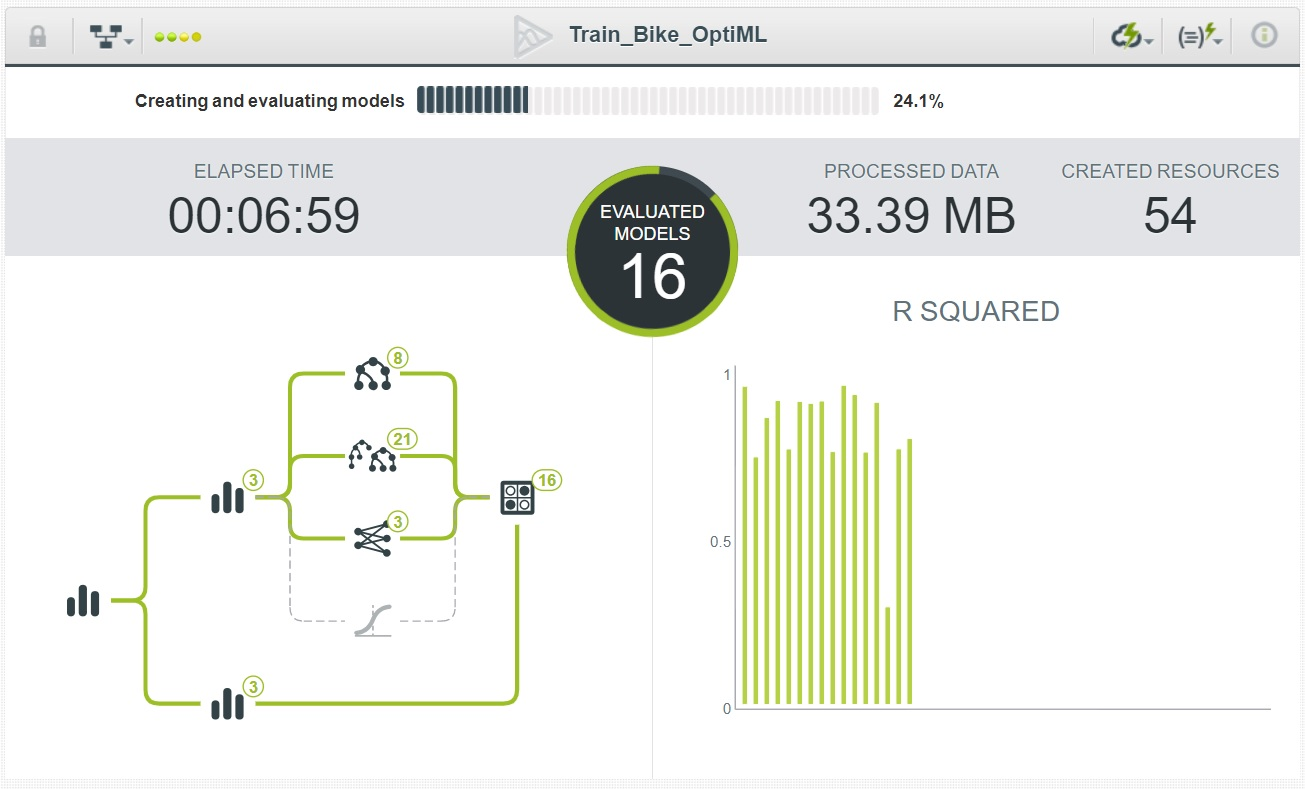

## OptiML Model Metrics

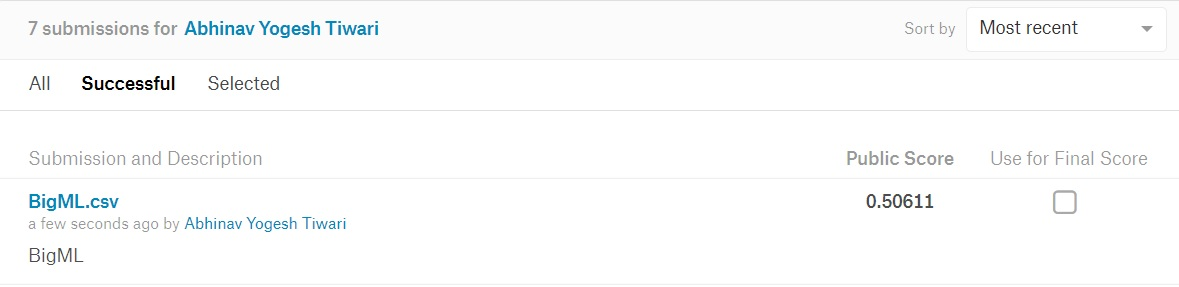